# Transfer Training and Prediction Results

In [43]:
from __future__ import print_function, division

import sys
import platform
import time
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

# this is necessary to use the common functions
# assumes directory structure was maintained
sys.path.insert(0, '../common/')
# from common.torch_utils import train_model,get_device
# from torch_utils import (train_model, 
#                          mnist_dataloader, 
#                          dataset_preview)
from torch_utils import *

# print some versions
print(f'Python Version:      {platform.python_version()}')
print(f'PyTorch Version:     {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')
print(f'CUDA Version:        {torch.version.cuda}')

# get device (defaults to GPU if available)
device = get_device()

Python Version:      3.7.8
PyTorch Version:     1.7.1+cu101
Torchvision Version: 0.8.2+cu101
CUDA Version:        10.1

***********************************
GPU Available:  True
Current Device: cuda:0 (Tesla V100-SXM2-16GB)
***********************************



## Data Preprocessing for Limited Dataset
We need to collect the MNIST data and create the dataloaders for PyTorch. To make a clean notebook, we have created a helper function to do most of the work (refer to `/src/common/torch_utils.py`). For training the base model, we will use a batch size of 32. 

Data will be located in '../../data'
Dataset sizes: {'train': 650, 'val': 103, 'pred': 6}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


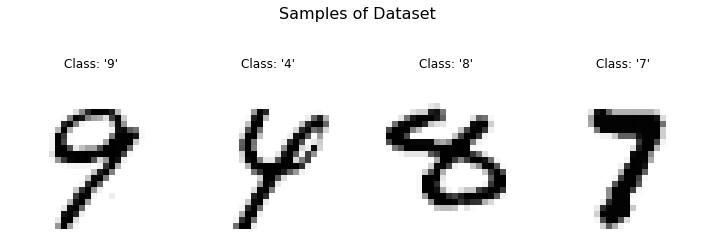

In [6]:
################################
# prepare the pre-trained model: 
#   Note the following considerations given our dataset for ResNet
#     -> MNIST data are 1-channel (grascale) of size and has 10 output classes
#     -> ResNet model expects 3-channel (RGB) images of size 224x224 as input 
#        and has 1000 output classes
#     == We must changet the last fully connected layer to match 10 classes
################################
PRETRAINED = True # <-- we will be finetunning
OUTPUT_DIR='output'
BATCH_SIZE = 32
NUM_CLASSES = 10
LIMITED_DATASET_SIZE = 650
NUM_EPOCHS = 100


data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

# use helper to create the dataloaders
tmp = mnist_dataloader(data_transforms,
                       batch_size=BATCH_SIZE,
                       sample_size=LIMITED_DATASET_SIZE,
                       pred_size=0.05)
dataloaders, dataset_sizes, class_names = tmp 
print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# define the set to use for testing the model
inputs, labels = next(iter(dataloaders['pred']))
inputs = inputs.cuda()

# preview the dataset
dataset_preview(dataloaders['train'])

## Train ResNet18 on the Limited Dataset

In [52]:
model_name = 'ResNet18'
model = models.resnet18(pretrained=PRETRAINED)
# modify the network to work with MNIST 28x28x1 with 10 outputs
num_features = model.fc.in_features # keep features unchanged
model.fc = nn.Linear(num_features, NUM_CLASSES) # output layer, 10 classes
model.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False) # first layer, single channel images

# use helper function to train the model (outputs model and Pandas DF)
print('\n'+'*'*40)
print(f'Training model \'{model_name}\' with limited dataset size of {LIMITED_DATASET_SIZE}...')
cudnn.benchmark = True
model, resnet18_df,_ = train_model(device, model, dataloaders, dataset_sizes, 
                                   output_dir=OUTPUT_DIR, status=10,
                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'{model_name}_size-{LIMITED_DATASET_SIZE}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
resnet18_df.to_csv(os.path.join(OUTPUT_DIR,results_file),
                  columns=resnet18_df.columns)
print(f'> Saved results to \'{results_file}\'.')


****************************************
Training model 'ResNet18' with limited dataset size of 650...

Epoch 0/99
----------
train Loss: 5.6619 Acc: 0.1723
val Loss: 4216.474 Acc: 0.1165
---------|9
Epoch 10/99
----------
train Loss: 1.1758 Acc: 0.5908
val Loss: 1.0813 Acc: 0.6311
---------|19
Epoch 20/99
----------
train Loss: 0.9486 Acc: 0.7785
val Loss: 0.8405 Acc: 0.767
---------|29
Epoch 30/99
----------
train Loss: 0.4586 Acc: 0.8585
val Loss: 0.7206 Acc: 0.7767
---------|39
Epoch 40/99
----------
train Loss: 0.265 Acc: 0.9077
val Loss: 0.609 Acc: 0.8252
---------|49
Epoch 50/99
----------
train Loss: 0.1568 Acc: 0.9508
val Loss: 0.5242 Acc: 0.8835
---------|59
Epoch 60/99
----------
train Loss: 0.1102 Acc: 0.9631
val Loss: 0.3717 Acc: 0.8738
---------|69
Epoch 70/99
----------
train Loss: 0.0431 Acc: 0.9908
val Loss: 0.3726 Acc: 0.8932
---------|79
Epoch 80/99
----------
train Loss: 0.0732 Acc: 0.9738
val Loss: 0.4522 Acc: 0.9223
---------|89
Epoch 90/99
----------
train Loss:

### Let's check Resnet18 with 2x, 5x, & 10x the data

In [44]:
# use helper to create the dataloaders
tmp = mnist_dataloader(data_transforms,
                       batch_size=BATCH_SIZE,
                       sample_size=LIMITED_DATASET_SIZE*2,
                       pred_size=0.05)
resnet18_1k, resnet18_1k_sizes, _ = tmp 
print(f"Dataset sizes: {resnet18_1k_sizes}")


# Let's run with 10x the data!
model_name = 'ResNet18-1k'
model_1k = models.resnet18(pretrained=PRETRAINED)
# modify the network to work with MNIST 28x28x1 with 10 outputs
num_features = model_1k.fc.in_features # keep features unchanged
model_1k.fc = nn.Linear(num_features, NUM_CLASSES) # output layer, 10 classes
model_1k.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False) # first layer, single channel images

# use helper function to train the model (outputs model and Pandas DF)
print('\n'+'*'*40)
print(f'Training model \'{model_name}\' with limited dataset size of {LIMITED_DATASET_SIZE}...')
cudnn.benchmark = True
model_1k, resnet18_1k_df,_ = train_model(device, model_1k, resnet18_1k, resnet18_1k_sizes, 
                                   output_dir=OUTPUT_DIR, status=10,
                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'{model_name}_size-6500_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
resnet18_1k_df.to_csv(os.path.join(OUTPUT_DIR,results_file),
                  columns=resnet18_1k_df.columns)
print(f'> Saved results to \'{results_file}\'.')

Data will be located in '../../data'
Dataset sizes: {'train': 1300, 'val': 206, 'pred': 11}

****************************************
Training model 'ResNet18-1k' with limited dataset size of 650...

Epoch 0/99
----------
train Loss: 9.4645 Acc: 0.1123
val Loss: 21394.7245 Acc: 0.0874
---------|9
Epoch 10/99
----------
train Loss: 0.7074 Acc: 0.7638
val Loss: 0.8581 Acc: 0.7427
---------|19
Epoch 20/99
----------
train Loss: 0.1432 Acc: 0.9531
val Loss: 0.4833 Acc: 0.8835
---------|29
Epoch 30/99
----------
train Loss: 0.0464 Acc: 0.9838
val Loss: 0.4483 Acc: 0.932
---------|39
Epoch 40/99
----------
train Loss: 0.016 Acc: 0.9938
val Loss: 0.219 Acc: 0.9466
---------|49
Epoch 50/99
----------
train Loss: 0.0038 Acc: 0.9985
val Loss: 0.1676 Acc: 0.9515
---------|59
Epoch 60/99
----------
train Loss: 0.0054 Acc: 0.9977
val Loss: 0.3393 Acc: 0.9272
---------|69
Epoch 70/99
----------
train Loss: 0.0108 Acc: 0.9954
val Loss: 0.2837 Acc: 0.9417
---------|79
Epoch 80/99
----------
train Loss

In [22]:
# use helper to create the dataloaders
tmp = mnist_dataloader(data_transforms,
                       batch_size=BATCH_SIZE,
                       sample_size=6500,
                       pred_size=0.05)
resnet18_6k, resnet18_6k_sizes, _ = tmp 
print(f"Dataset sizes: {resnet18_6k_sizes}")


# Let's run with 10x the data!
model_name = 'ResNet18-6k'
model_6k = models.resnet18(pretrained=PRETRAINED)
# modify the network to work with MNIST 28x28x1 with 10 outputs
num_features = model_6k.fc.in_features # keep features unchanged
model_6k.fc = nn.Linear(num_features, NUM_CLASSES) # output layer, 10 classes
model_6k.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False) # first layer, single channel images

# use helper function to train the model (outputs model and Pandas DF)
print('\n'+'*'*40)
print(f'Training model \'{model_name}\' with limited dataset size of {LIMITED_DATASET_SIZE}...')
cudnn.benchmark = True
model_6k, resnet18_6k_df,_ = train_model(device, model_6k, resnet18_6k, resnet18_6k_sizes, 
                                   output_dir=OUTPUT_DIR, status=10,
                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'{model_name}_size-6500_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
resnet18_6k_df.to_csv(os.path.join(OUTPUT_DIR,results_file),
                  columns=resnet18_6k_df.columns)
print(f'> Saved results to \'{results_file}\'.')

Data will be located in '../../data'
Dataset sizes: {'train': 6500, 'val': 1029, 'pred': 55}

****************************************
Training model 'ResNet18-6k' with limited dataset size of 650...

Epoch 0/99
----------
train Loss: 5.2098 Acc: 0.2865
val Loss: 1.9189 Acc: 0.3382
---------|9
Epoch 10/99
----------
train Loss: 0.1503 Acc: 0.9528
val Loss: 0.1984 Acc: 0.9534
---------|19
Epoch 20/99
----------
train Loss: 0.0974 Acc: 0.9695
val Loss: 0.1396 Acc: 0.966
---------|29
Epoch 30/99
----------
train Loss: 0.055 Acc: 0.9809
val Loss: 0.1452 Acc: 0.965
---------|39
Epoch 40/99
----------
train Loss: 0.0484 Acc: 0.9846
val Loss: 0.1103 Acc: 0.9699
---------|49
Epoch 50/99
----------
train Loss: 0.0266 Acc: 0.9909
val Loss: 0.1001 Acc: 0.9815
---------|59
Epoch 60/99
----------
train Loss: 0.0305 Acc: 0.9906
val Loss: 0.1442 Acc: 0.9738
---------|69
Epoch 70/99
----------
train Loss: 0.0284 Acc: 0.99
val Loss: 0.1244 Acc: 0.9738
---------|79
Epoch 80/99
----------
train Loss: 0.0

             training_time  validation_time
model                                      
resnet18         45.276058        62.294495
resnet18_1k      73.411499        94.552920
resnet18_6k     288.079381       326.710458



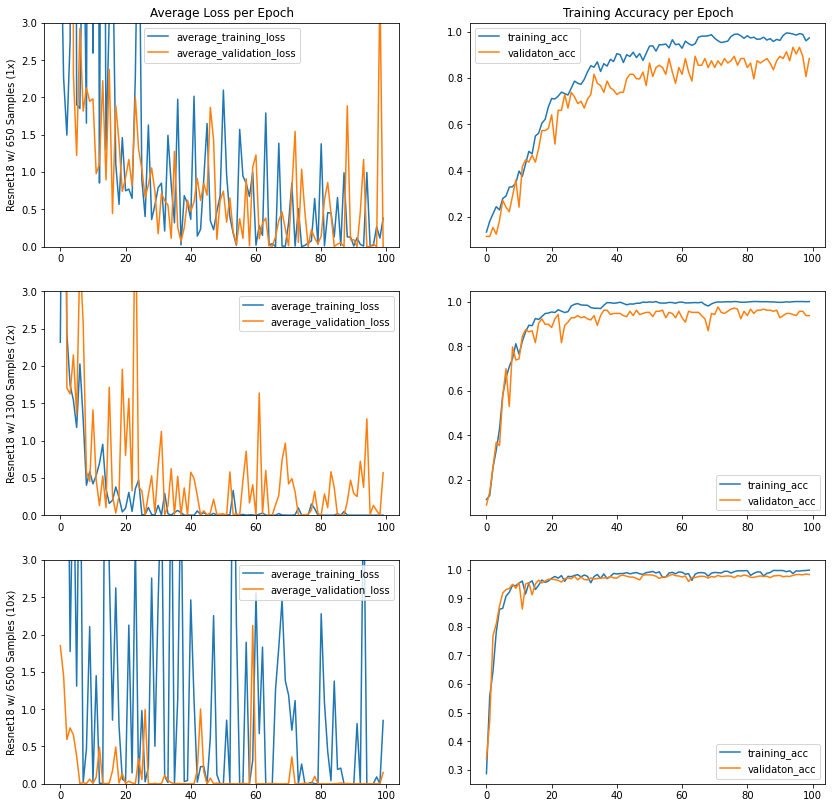

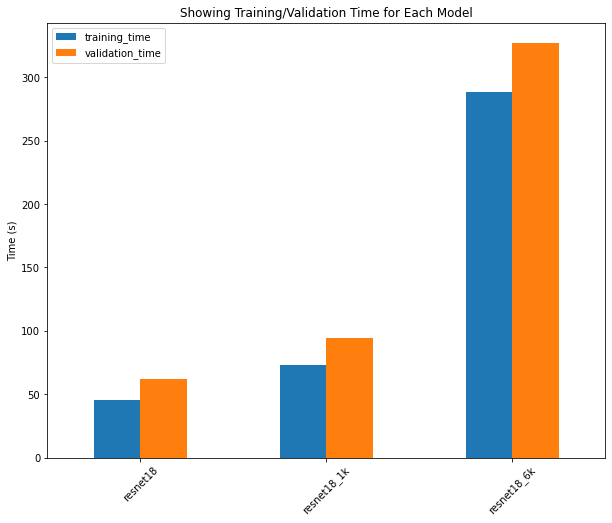

In [50]:
## Compare all of the training/validation times
# collect all model outputs
model_dict = {'resnet18': resnet18_df, 'resnet18_1k': resnet18_1k_df,'resnet18_6k': resnet18_6k_df}
dfs = []
for m in model_dict: 
    # do some cleanup and make a model column
    df = model_dict[m].set_index('epoch').copy()
    df['model'] = m
    dfs.append(df)
    
# plot performance curves
loss_df = pd.concat(dfs).groupby(['model'])[["average_training_loss", "average_validation_loss"]]
acc_df = pd.concat(dfs).groupby(['model'])[["training_acc", "validaton_acc"]]

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(14,14))
resnet18_df.plot(y=['average_training_loss','average_validation_loss'], ax=axes[0,0])
resnet18_1k_df.plot(y=['average_training_loss','average_validation_loss'], ax=axes[1,0])
resnet18_6k_df.plot(y=['average_training_loss','average_validation_loss'], ax=axes[2,0])

axes[0,0].set_ylim([0,3])
axes[1,0].set_ylim([0,3])
axes[2,0].set_ylim([0,3])

resnet18_df.plot(y=['training_acc','validaton_acc'],ax=axes[0,1])
resnet18_1k_df.plot(y=['training_acc','validaton_acc'],ax=axes[1,1])
resnet18_6k_df.plot(y=['training_acc','validaton_acc'],ax=axes[2,1])

# titles and such
axes[0,0].set_title('Average Loss per Epoch')
axes[0,1].set_title('Training Accuracy per Epoch')
axes[0,0].set_ylabel('Resnet18 w/ 650 Samples (1x)')
axes[1,0].set_ylabel('Resnet18 w/ 1300 Samples (2x)')
axes[2,0].set_ylabel('Resnet18 w/ 6500 Samples (10x)')




# concatenetate all model results and sum up the times
time_df = pd.concat(dfs) \
            .groupby(['model'])[["training_time", "validation_time"]] \
            .apply(lambda x : x.astype(float).sum())

# show the times
print(time_df)
print()
# plot the times
fig2 = time_df.plot.bar(figsize=(10,8)).get
plt.title('Showing Training/Validation Time for Each Model')
# other it'll show up as 'dummy' 
plt.ylabel('Time (s)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()

## Evaluate Res

In [51]:
# Evaluate the model using the prediction set held-off
model.eval()
# make predictions an plot the results
fig = plot_classes_preds(model,inputs,labels,class_names) 
plt.plot()

# plot performance curves
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
resnet18_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'], ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,3])
resnet18_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuract per Epoch')

img_file = f'loss_{model_name}_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(OUTPUT_DIR,img_file))

AttributeError: 'str' object has no attribute 'eval'

### Preliminary look at training/validation time

          training_time  validation_time
model                                   
resnet18      45.276058        62.294495



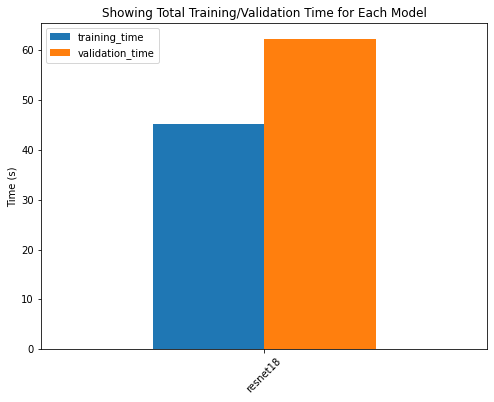

In [17]:
## Compare all of the training/validation times
df = resnet18_df.set_index('epoch').copy()
df['model'] = 'resnet18'
# concatenetate all model results and sum up the times
time_df = df.groupby(['model'])[["training_time", "validation_time"]] \
            .apply(lambda x : x.astype(float).sum())

# show the times
print(time_df)
print()
# plot the times
fig = time_df.plot.bar(figsize=(8,6))
plt.title('Showing Total Training/Validation Time for Each Model')
# other it'll show up as 'dummy' 
plt.ylabel('Time (s)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()

## Train ResNet50 on the Limited Dataset

In [16]:
model_name = 'ResNet50'
model = models.resnet50(pretrained=PRETRAINED)
# modify the network to work with MNIST 28x28x1 with 10 outputs
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, NUM_CLASSES)
model.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)

# use helper function to train the model (outputs model and Pandas DF)
print('\n'+'*'*40)
print(f'Training model \'{model_name}\' with limited dataset size of {LIMITED_DATASET_SIZE}...')
cudnn.benchmark = True
model, resnet50_df,_ = train_model(device, model, dataloaders, dataset_sizes, 
                                   output_dir=OUTPUT_DIR, status=10,
                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'{model_name}_size-{LIMITED_DATASET_SIZE}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
resnet50_df.to_csv(os.path.join(OUTPUT_DIR,results_file),
                  columns=resnet50_df.columns)
print(f'> Saved results to \'{results_file}\'.')


****************************************
Training model 'ResNet50' with limited dataset size of 650...

Epoch 0/99
----------
train Loss: 12.3011 Acc: 0.1108
val Loss: 589411298174.7573 Acc: 0.1068
---------|9
Epoch 10/99
----------
train Loss: 1.6694 Acc: 0.4092
val Loss: 1.729 Acc: 0.4175
---------|19
Epoch 20/99
----------
train Loss: 1.061 Acc: 0.6292
val Loss: 1.4909 Acc: 0.5437
---------|29
Epoch 30/99
----------
train Loss: 1.0415 Acc: 0.6585
val Loss: 1.259 Acc: 0.6214
---------|39
Epoch 40/99
----------
train Loss: 0.8667 Acc: 0.6923
val Loss: 1.2613 Acc: 0.5922
---------|49
Epoch 50/99
----------
train Loss: 0.3656 Acc: 0.8692
val Loss: 0.946 Acc: 0.699
---------|59
Epoch 60/99
----------
train Loss: 0.2877 Acc: 0.9
val Loss: 0.9815 Acc: 0.7961
---------|69
Epoch 70/99
----------
train Loss: 0.1761 Acc: 0.9308
val Loss: 1.0251 Acc: 0.7573
---------|79
Epoch 80/99
----------
train Loss: 0.2063 Acc: 0.9369
val Loss: 0.9283 Acc: 0.8155
---------|89
Epoch 90/99
----------
train 

## Evaluate ResNet50

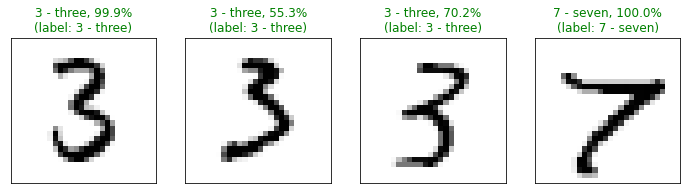

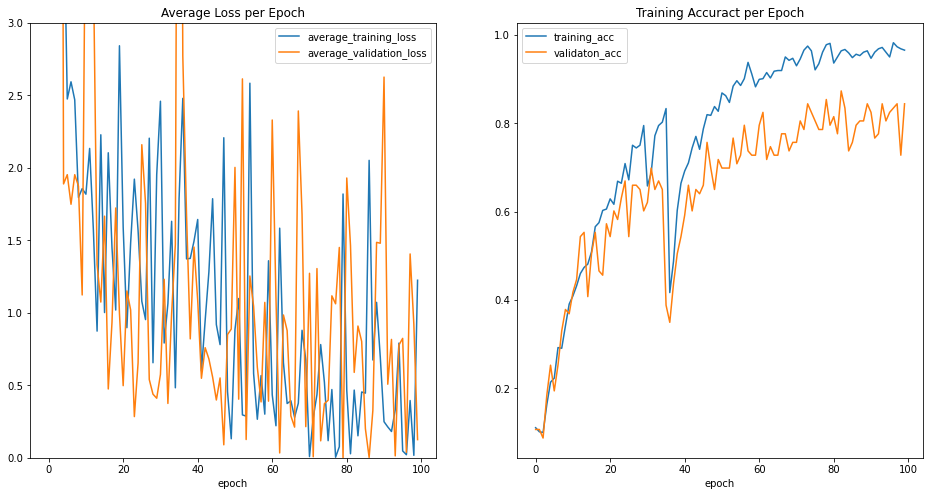

In [18]:
# Evaluate the model using the prediction set held-off
model.eval()
# make predictions an plot the results
fig = plot_classes_preds(model,inputs,labels,class_names) 
plt.plot()

# plot performance curves
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
resnet50_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,3])
resnet50_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuract per Epoch')

img_file = f'loss_{model_name}_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(OUTPUT_DIR,img_file))

          training_time  validation_time
model                                   
resnet50      83.620959       106.417532



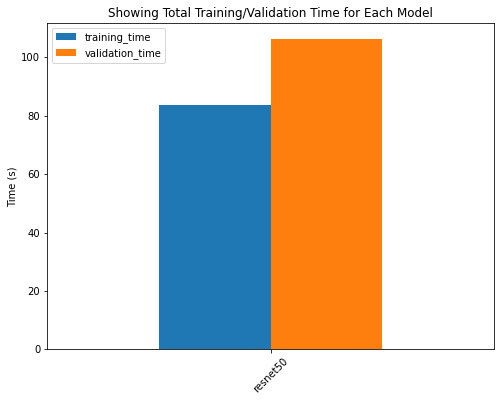

In [19]:
## Compare all of the training/validation times
df = resnet50_df.set_index('epoch').copy()
df['model'] = 'resnet50'
# concatenetate all model results and sum up the times
time_df = df.groupby(['model'])[["training_time", "validation_time"]] \
            .apply(lambda x : x.astype(float).sum())

# show the times
print(time_df)
print()
# plot the times
fig = time_df.plot.bar(figsize=(8,6))
plt.title('Showing Total Training/Validation Time for Each Model')
# other it'll show up as 'dummy' 
plt.ylabel('Time (s)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()

## Train VGG11 on the Limited Dataset

In [95]:
model_name = 'VGG11'
model = models.vgg11(pretrained=PRETRAINED)
# modify the network to work with MNIST 28x28x1 with 10 outputs
num_features = model.classifier[6].in_features
model.features[0] = torch.nn.Conv2d(1, 64, 3, 1, 1)
model.features = torch.nn.Sequential(*[model.features[ii] for ii in range(15)])
model.classifier = torch.nn.Sequential(*[model.classifier[jj] for jj in range(4)])
model.classifier[-1] = torch.nn.Linear(num_features, NUM_CLASSES)

# use helper function to train the model (outputs model and Pandas DF)
print('\n'+'*'*40)
print(f'Training model \'{model_name}\' with limited dataset size of {LIMITED_DATASET_SIZE}...')
cudnn.benchmark = True
model, vgg11_df,_ = train_model(device, model, dataloaders, dataset_sizes, 
                                   output_dir=OUTPUT_DIR, status=10,
                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'{model_name}_size-{LIMITED_DATASET_SIZE}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
vgg11_df.to_csv(os.path.join(OUTPUT_DIR,results_file),
                  columns=vgg11_df.columns)
print(f'> Saved results to \'{results_file}\'.')


****************************************
Training model 'VGG11' with limited dataset size of 650...

Epoch 0/9
----------
train Loss: nan Acc: 0.1015
val Loss: nan Acc: 0.1068
--------|8
Epoch 9/9
----------
train Loss: nan Acc: 0.0985
val Loss: nan Acc: 0.1068
Training complete in 0.0m 7.063429117202759s
Best val Acc: 0.1068
> Saved results to 'VGG11_size-650_results_2020-12-16T030442.csv'.


## Evaluate VGG11

[]

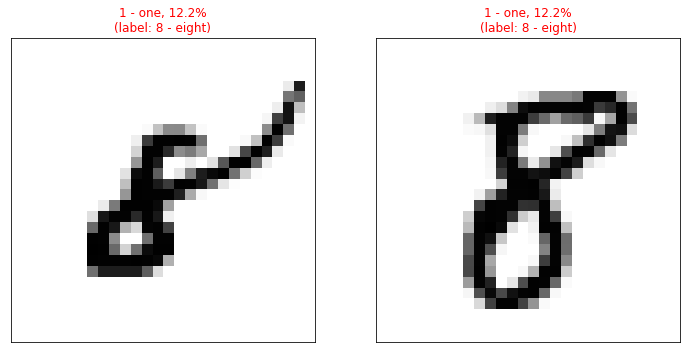

In [17]:
# Evaluate the model using the prediction set held-off
model.eval()
# make predictions an plot the results
fig = plot_classes_preds(model,inputs,labels,class_names) 
plt.plot()

# plot performance curves
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
vgg11_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,3])
vgg11_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuract per Epoch')

img_file = f'loss_{model_name}_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(OUTPUT_DIR,img_file))

## Train VGG16 on the Limited Dataset

In [96]:
model_name = 'VGG16'
model = models.vgg16(pretrained=PRETRAINED)
# modify the network to work with MNIST 28x28x1 with 10 outputs
num_features = model.classifier[6].in_features
model.features[0] = torch.nn.Conv2d(1, 64, 3, 1, 1)
model.features = torch.nn.Sequential(*[model.features[ii] for ii in range(23)])
model.classifier = torch.nn.Sequential(*[model.classifier[jj] for jj in range(4)])
model.classifier[-1] = torch.nn.Linear(num_features, NUM_CLASSES)

# use helper function to train the model (outputs model and Pandas DF)
print('\n'+'*'*40)
print(f'Training model \'{model_name}\' with limited dataset size of {LIMITED_DATASET_SIZE}...')
cudnn.benchmark = True
model, vgg16_df,_ = train_model(device, model, dataloaders, dataset_sizes, 
                                   output_dir=OUTPUT_DIR, status=10,
                                    num_epochs=NUM_EPOCHS)
# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'{model_name}_size-{LIMITED_DATASET_SIZE}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
vgg16_df.to_csv(os.path.join(OUTPUT_DIR,results_file),
                  columns=vgg16_df.columns)
print(f'> Saved results to \'{results_file}\'.')


****************************************
Training model 'VGG16' with limited dataset size of 650...

Epoch 0/9
----------
train Loss: nan Acc: 0.0754
val Loss: nan Acc: 0.1068
--------|8
Epoch 9/9
----------
train Loss: nan Acc: 0.0985
val Loss: nan Acc: 0.1068
Training complete in 0.0m 7.566320419311523s
Best val Acc: 0.1068
> Saved results to 'VGG16_size-650_results_2020-12-16T030450.csv'.


## Evaluate VGG16

[]

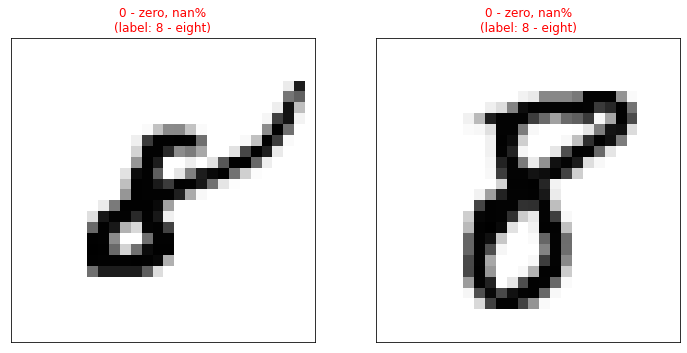

In [19]:
# Evaluate the model using the prediction set held-off
model.eval()
# make predictions an plot the results
fig = plot_classes_preds(model,inputs,labels,class_names) 
plt.plot()

# plot performance curves
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
vgg16_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,3])
vgg16_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuract per Epoch')

img_file = f'loss_{model_name}_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(OUTPUT_DIR,img_file))

## Train DenseNet161 on the Limited Dataset

In [97]:
model_name = 'DenseNet161'
model =  models.densenet161(pretrained=PRETRAINED)
# modify the network to work with MNIST 28x28x1 with 10 outputs
model.features.conv0 = torch.nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.features.pool0 = torch.nn.Identity()
model.classifier = torch.nn.Linear(2208, NUM_CLASSES, bias=True)

# use helper function to train the model (outputs model and Pandas DF)
print('\n'+'*'*40)
print(f'Training model \'{model_name}\' with limited dataset size of {LIMITED_DATASET_SIZE}...')
cudnn.benchmark = True
model, densnet161_df,_ = train_model(device, model, dataloaders, dataset_sizes, 
                                   output_dir=OUTPUT_DIR, status=10,
                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'{model_name}_size-{LIMITED_DATASET_SIZE}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
densnet161_df.to_csv(os.path.join(OUTPUT_DIR,results_file),
                  columns=densnet161_df.columns)
print(f'> Saved results to \'{results_file}\'.')


****************************************
Training model 'DenseNet161' with limited dataset size of 650...

Epoch 0/9
----------
train Loss: 10.6758 Acc: 0.0908
val Loss: 6591462280288634.0 Acc: 0.0874
--------|8
Epoch 9/9
----------
train Loss: 1.5676 Acc: 0.4754
val Loss: 1.5038 Acc: 0.4563
Training complete in 0.0m 30.757423162460327s
Best val Acc: 0.5146
> Saved results to 'DenseNet161_size-650_results_2020-12-16T030522.csv'.


## Evaluate DesneNet161

In [ ]:
# Evaluate the model using the prediction set held-off
model.eval()
# make predictions an plot the results
fig = plot_classes_preds(model,inputs,labels,class_names) 
plt.plot()

# plot performance curves
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
densnet161_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,3])
densnet161_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuract per Epoch')

img_file = f'loss_{model_name}_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(OUTPUT_DIR,img_file))

## Compare times from all models

          training_time  validation_time
model                                   
resnet18       4.524335         6.353591
resnet50       8.302803        10.551234
vgg11          4.420199         6.074397
vgg16          4.839115         6.552462



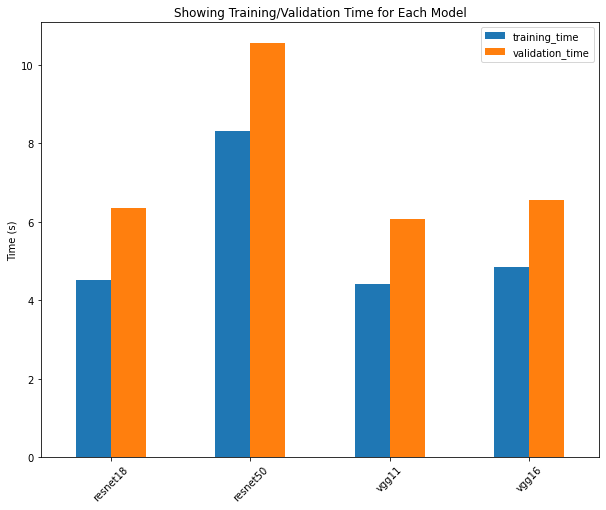

In [105]:
## Compare all of the training/validation times
# collect all model outputs
model_dict = {'resnet18': resnet18_df, 'resnet50': resnet50_df,'vgg11':vgg11_df,'vgg16':vgg16_df}
dfs = []
for model in models: 
    # do some cleanup and make a model column
    df = model_dict[model].set_index('epoch').copy()
    df['model'] = model
    dfs.append(df)
# concatenetate all model results and sum up the times
time_df = pd.concat(dfs) \
            .groupby(['model'])[["training_time", "validation_time"]] \
            .apply(lambda x : x.astype(float).sum())

# show the times
print(time_df)
print()
# plot the times
time_df.plot.bar(figsize=(10,8))
plt.title('Showing Training/Validation Time for Each Model')
# other it'll show up as 'dummy' 
plt.ylabel('Time (s)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()